### Загрузка данных и подготовка к анализу

##### Приложение Procrastinate Pro+ последние несколько месяцев терпит убытки, несмотря на огромные вложения в рекламу. Цель проекта - разобраться в данной ситуации и обозначить причины её возникновения.

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np

In [133]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net/datasets/visits_info_short.csv')
    
visits.head() 

User Id         Region   Device  Channel        Session Start  \
0  981449118918  United States   iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States      Mac  organic  2019-05-01 14:09:25   
3  326433527971  United States  Android   TipTop  2019-05-01 00:29:59   
4  349773784594  United States      Mac  organic  2019-05-01 03:33:35   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08  
3  2019-05-01 00:54:25  
4  2019-05-01 03:57:40

In [134]:
try:
    orders = pd.read_csv('/datasets/orders_info_short.csv')
except:
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders_info_short.csv')
    
orders.head() 

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99
3  319939546352  2019-05-01 15:34:40     4.99
4  366000285810  2019-05-01 13:59:51     4.99

In [135]:
try:
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    costs = pd.read_csv('https://code.s3.yandex.net/datasets/costs_info_short.csv')
    
costs.head() 

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8
3  2019-05-04  FaceBoom  136.4
4  2019-05-05  FaceBoom  122.1

### Предобработка данных

In [136]:
visits.columns = visits.columns.str.lower()
visits.rename(columns = 
              {'user id':'user_id', 'session start':'session_start','session end':'session_end'}, 
              inplace = True )

visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user_id        309901 non-null  int64 
 1   region         309901 non-null  object
 2   device         309901 non-null  object
 3   channel        309901 non-null  object
 4   session_start  309901 non-null  object
 5   session_end    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [137]:
# привести колонки 'session_start' и 'session_end' к типу datetime

visits['session_start'] = pd.to_datetime(visits['session_start'])

visits['session_end'] = pd.to_datetime(visits['session_end'])

In [138]:
orders.columns = orders.columns.str.lower()
orders.rename(columns = 
              {'user id':'user_id', 'event dt':'event_dt'}, 
              inplace = True )

orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   40212 non-null  int64  
 1   event_dt  40212 non-null  object 
 2   revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [139]:
# привести колонку 'event_dt' к типу datetime

orders['event_dt'] = pd.to_datetime(orders['event_dt'])

In [140]:
costs.columns = costs.columns.str.lower()
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [141]:
# привести колонку 'dt' к типу datetime

costs['dt'] = pd.to_datetime(costs['dt']).dt.date

In [142]:
#поиск дубликатов

print('visits:', visits.duplicated().sum())
print('orders:', orders.duplicated().sum())
print('costs:', costs.duplicated().sum())

visits: 0
orders: 0
costs: 0


Пропуски и дубликаты отсутствуют

#### Функция для создания профилей пользователя

In [143]:
def get_profiles(visits, orders, ad_costs):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

#### Функция для подсчёта Retention Rate

In [144]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

#### Функция для подсчёта конверсии

In [145]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions: 
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return result_raw, result_grouped, result_in_time 

#### Функция для подсчёта LTV и ROI

In [146]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,
        result_grouped,
        result_in_time,
        roi_grouped,
        roi_in_time,
    ) 

#### Функция для сглаживания данных

In [147]:
def filter_data(df, window):

    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

#### Функция для построения графика Retention Rate

In [148]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]

    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

#### Функция для построения графика конверсии

In [149]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))

    conversion = conversion.drop(columns=['cohort_size'])
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

#### Функция для визуализации LTV и ROI

In [150]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)

    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)

    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)

    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

### Исследовательский анализ данных


In [151]:
# профили пользователей

profiles = get_profiles(visits, orders, costs)
print(profiles.head(5)) 

    user_id            first_ts     channel  device         region  \
0    599326 2019-05-07 20:58:57    FaceBoom     Mac  United States   
1   4919697 2019-07-09 12:46:07    FaceBoom  iPhone  United States   
2   6085896 2019-10-01 09:58:33     organic  iPhone         France   
3  22593348 2019-08-22 21:35:48  AdNonSense      PC        Germany   
4  31989216 2019-10-02 00:07:44     YRabbit  iPhone  United States   

           dt      month  payer  acquisition_cost  
0  2019-05-07 2019-05-01   True          1.088172  
1  2019-07-09 2019-07-01  False          1.107237  
2  2019-10-01 2019-10-01  False          0.000000  
3  2019-08-22 2019-08-01  False          0.988235  
4  2019-10-02 2019-10-01  False          0.230769  


In [152]:
print('Минимальная дата привлечения пользователей:', profiles['dt'].min())
print('Максимальная дата привлечения пользователей:', profiles['dt'].max())

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


In [153]:
def pro_piv(column):
    
    profiles_piv = (profiles.groupby(column)
                   .agg({'user_id':['count'],'payer':['mean']})
                   .sort_values([('payer', 'mean')], ascending = False))

    return profiles_piv
    

In [154]:
# построить сводную таблицу по странам

pro_piv(profiles['region'])

user_id     payer
                count      mean
region                         
United States  100002  0.069019
Germany         14981  0.041119
UK              17575  0.039829
France          17450  0.037994

Больше всего платящих пользователей в стране - США

In [155]:
# построить сводную таблицу по устройствам

pro_piv(profiles['device'])

user_id     payer
          count      mean
device                   
Mac       30042  0.063644
iPhone    54479  0.062079
Android   35032  0.058518
PC        30455  0.050468

Самая высокая доля платящих клиентов среди пользователей устройства Mac

In [156]:
# построить сводную таблицу по каналам привлечения

pro_piv(profiles['channel'])

user_id     payer
                     count      mean
channel                             
FaceBoom             29144  0.122049
AdNonSense            3880  0.113402
lambdaMediaAds        2149  0.104700
TipTop               19561  0.096007
RocketSuperAds        4448  0.079137
WahooNetBanner        8553  0.052964
YRabbit               4312  0.038265
MediaTornado          4364  0.035747
LeapBob               8553  0.030633
OppleCreativeMedia    8605  0.027077
organic              56439  0.020553

Больше всего платящих пользователей пришло из канала FaceBoom

### Маркетинг


In [157]:
print('Общая сумма расходов на маркетинг:', costs['costs'].sum().round(2))

Общая сумма расходов на маркетинг: 105497.3


In [158]:
# построить сводную таблицу по каналам привлечения

costs_pivot = (
    costs.groupby('channel')
    .agg({'costs':['sum']})
    .sort_values([('costs', 'sum')], ascending = False)
)
    
costs_pivot['share'] = costs_pivot['costs', 'sum'] / costs['costs'].sum() 
    
costs_pivot

costs     share
                         sum          
channel                               
TipTop              54751.30  0.518983
FaceBoom            32445.60  0.307549
WahooNetBanner       5151.00  0.048826
AdNonSense           3911.25  0.037074
OppleCreativeMedia   2151.25  0.020392
RocketSuperAds       1833.00  0.017375
LeapBob              1797.60  0.017039
lambdaMediaAds       1557.60  0.014764
MediaTornado          954.48  0.009047
YRabbit               944.22  0.008950

Больше средств всего потрачено на источники TipTop и FaceBoom. Менее 20% всех расходов на рекламу приходится на другие источники привлчения.

In [159]:
costs['week'] = costs['dt'].astype('datetime64[W]')
costs['month'] = costs['dt'].astype('datetime64[M]')

costs

dt         channel  costs       week      month
0     2019-05-01        FaceBoom  113.3 2019-04-25 2019-05-01
1     2019-05-02        FaceBoom   78.1 2019-05-02 2019-05-01
2     2019-05-03        FaceBoom   85.8 2019-05-02 2019-05-01
3     2019-05-04        FaceBoom  136.4 2019-05-02 2019-05-01
4     2019-05-05        FaceBoom  122.1 2019-05-02 2019-05-01
...          ...             ...    ...        ...        ...
1795  2019-10-23  lambdaMediaAds    4.0 2019-10-17 2019-10-01
1796  2019-10-24  lambdaMediaAds    6.4 2019-10-24 2019-10-01
1797  2019-10-25  lambdaMediaAds    8.8 2019-10-24 2019-10-01
1798  2019-10-26  lambdaMediaAds    8.8 2019-10-24 2019-10-01
1799  2019-10-27  lambdaMediaAds   12.0 2019-10-24 2019-10-01

[1800 rows x 5 columns]

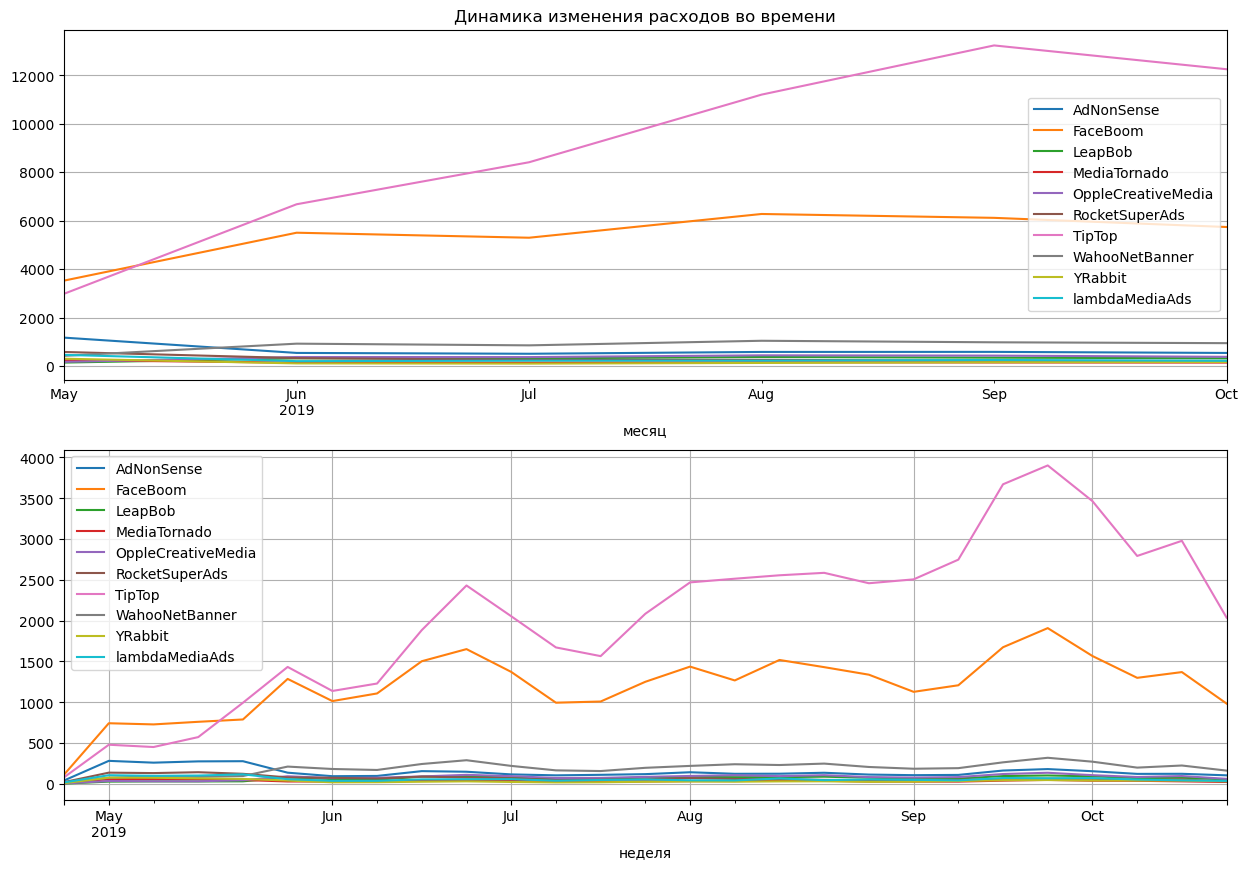

In [160]:
plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2, 1, 1)
costs.pivot_table(index='month', 
                  columns= 'channel',
                  values='costs',
                  aggfunc='sum').plot(grid=True, ax=ax1)

plt.legend()
plt.xlabel('месяц')
plt.title('Динамика изменения расходов во времени')
ax2 = plt.subplot(2, 1, 2)
costs.pivot_table(index='week', 
                  columns= 'channel',
                  values='costs',
                  aggfunc='sum').plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('неделя')
plt.show()


Расходы на рекламу по источникам FaceBoom и TipTop повышались, в то время как по другим каналам практически не менялись

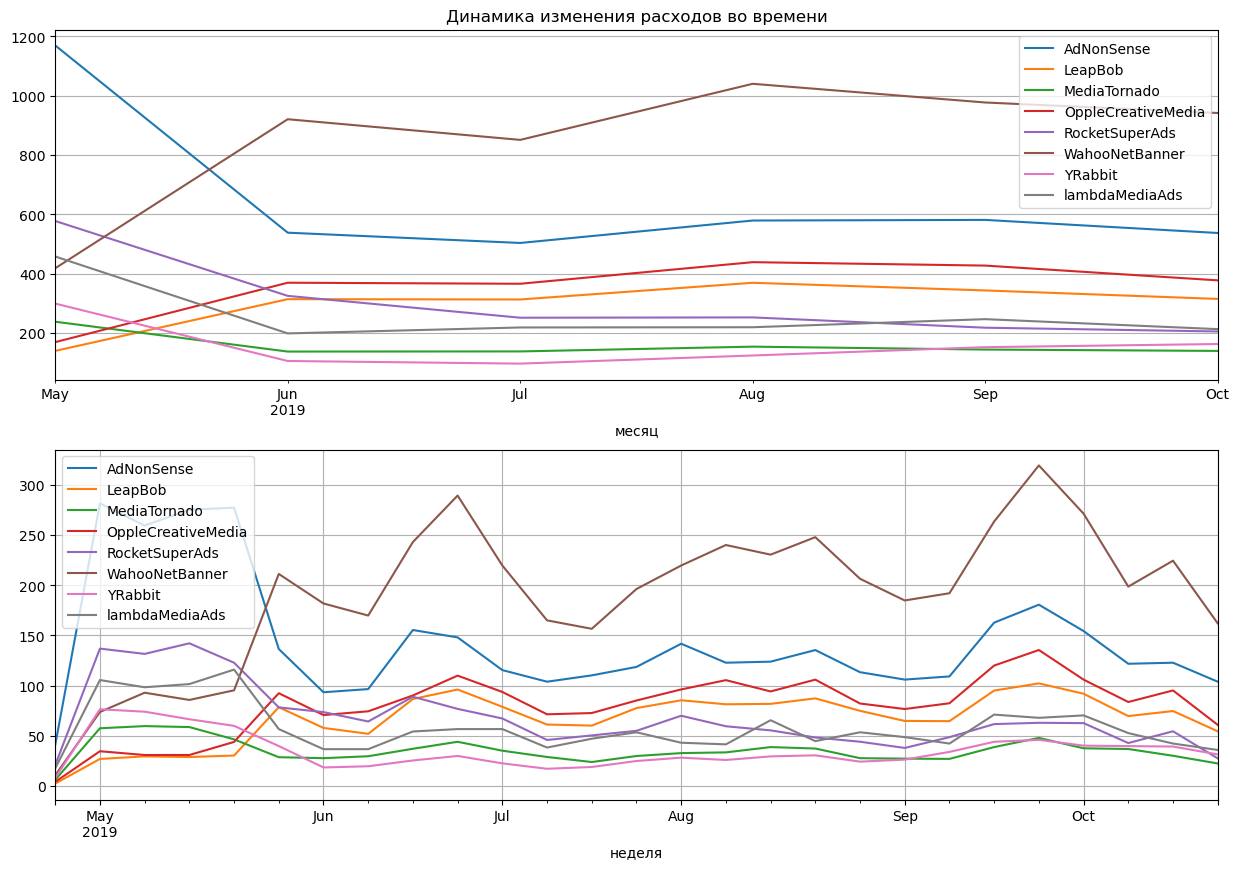

In [161]:
# аналогичные графики, но без каналов TipTop и FaceBoom

plt.figure(figsize=(15, 10))
ax1 = plt.subplot(2, 1, 1)
costs.query('channel!= "FaceBoom" and channel!= "TipTop"').pivot_table(index='month', 
                                                                      columns= 'channel',
                                                                      values='costs',
                                                                      aggfunc='sum').plot(grid=True, ax=ax1)

plt.legend()
plt.xlabel('месяц')
plt.title('Динамика изменения расходов во времени')
ax2 = plt.subplot(2, 1, 2)
costs.query('channel!= "FaceBoom" and channel!= "TipTop"').pivot_table(index='week', 
                                                                      columns= 'channel',
                                                                      values='costs',
                                                                      aggfunc='sum').plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('неделя')
plt.show()

Расходы по каналу AdNonSense резко снизились в мае и не менялись остальные месяцы.
Расходы по каналу WahooNetBanner увеличились в мае.

In [162]:
# построить сводную таблицу по каналам привлечения и САС

profiles.pivot_table(
    index='channel', values='acquisition_cost', aggfunc='mean'
).sort_values([('acquisition_cost')], ascending = False)

acquisition_cost
channel                             
TipTop                      2.799003
FaceBoom                    1.113286
AdNonSense                  1.008054
lambdaMediaAds              0.724802
WahooNetBanner              0.602245
RocketSuperAds              0.412095
OppleCreativeMedia          0.250000
YRabbit                     0.218975
MediaTornado                0.218717
LeapBob                     0.210172
organic                     0.000000

In [163]:
print('Средний CAC:', profiles['acquisition_cost'].mean())

Средний CAC: 0.7032778251827625


Самая высокая стоимость привлечения одного пользователя - у канала TipTop

### Оценка окупаемости рекламы

In [164]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

In [165]:
#исключить источник привлечения - organic

profiles = profiles.query('channel != "organic"')

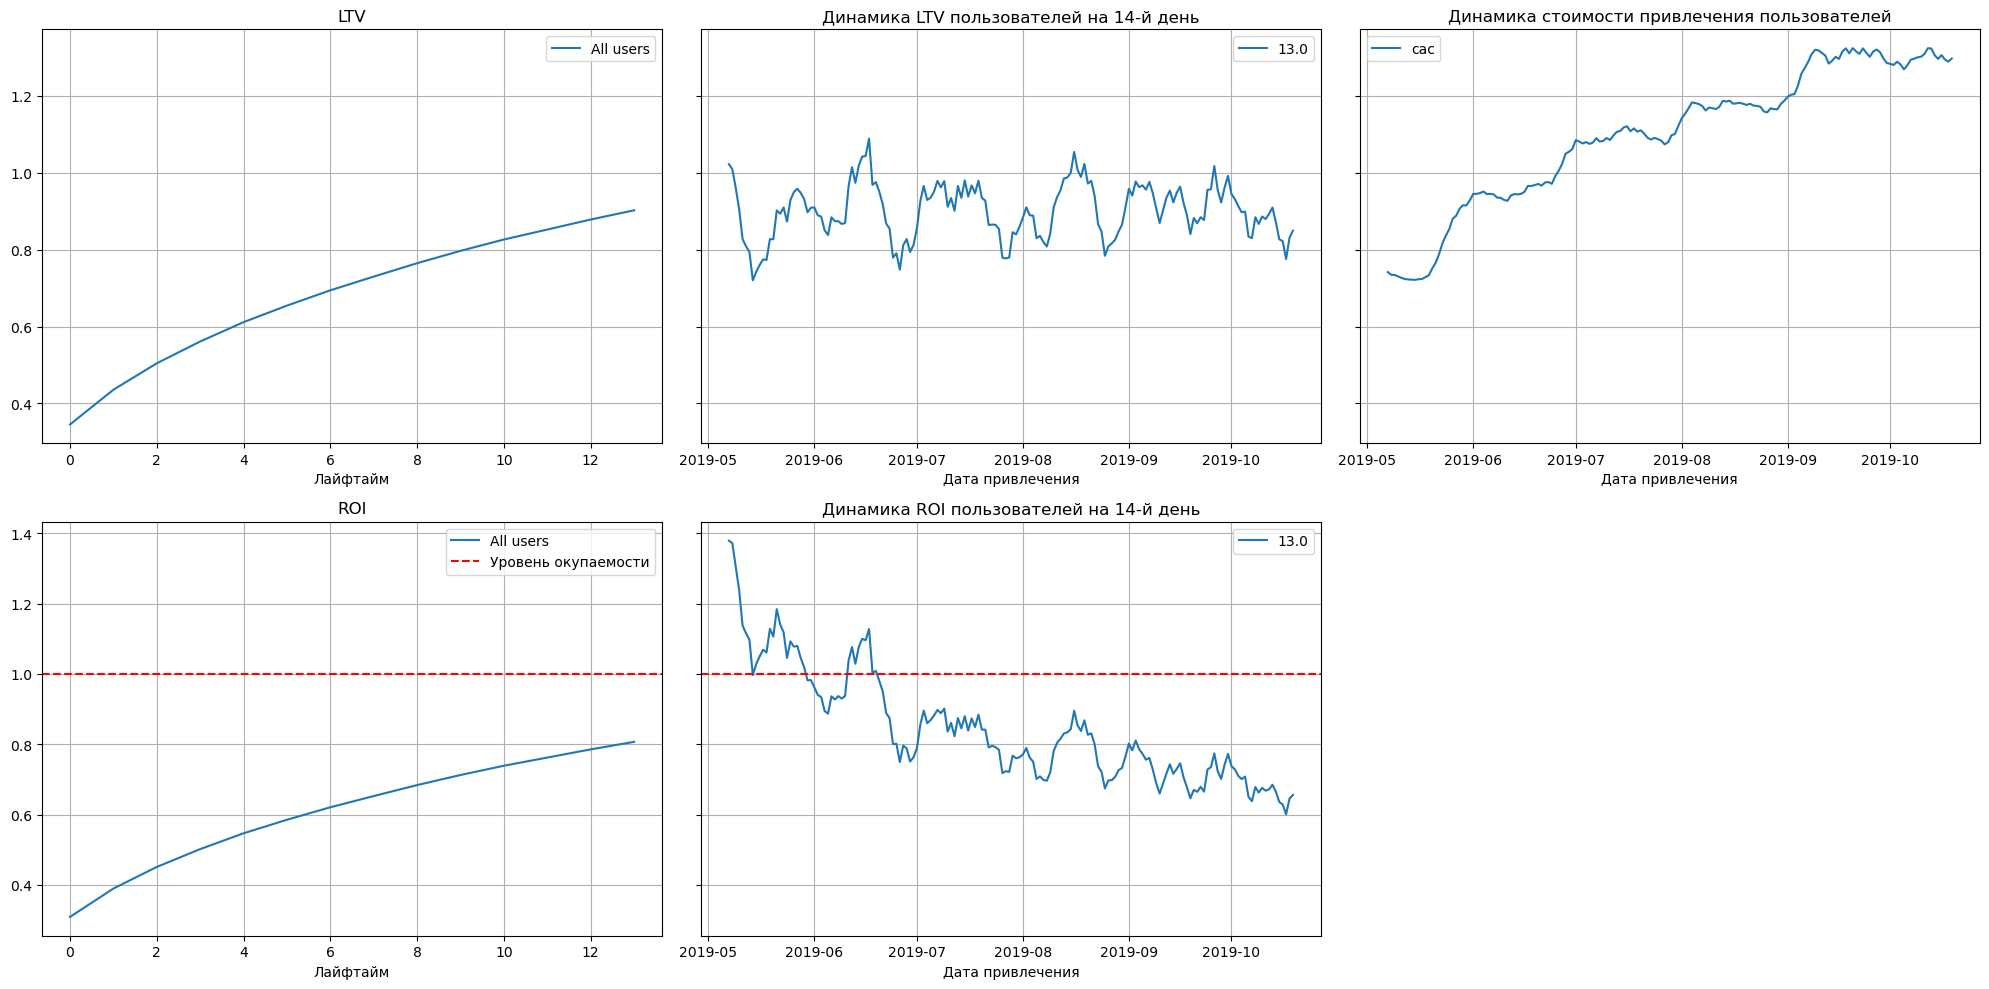

In [166]:
# графики LTV, ROI, CAC

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

Реклама не окупается. ROI к концу недели доходит до 80%. После мая ROI начал резко снижаться.
CAC увеличивается от месяца к месяцу.
LTV стабилен.


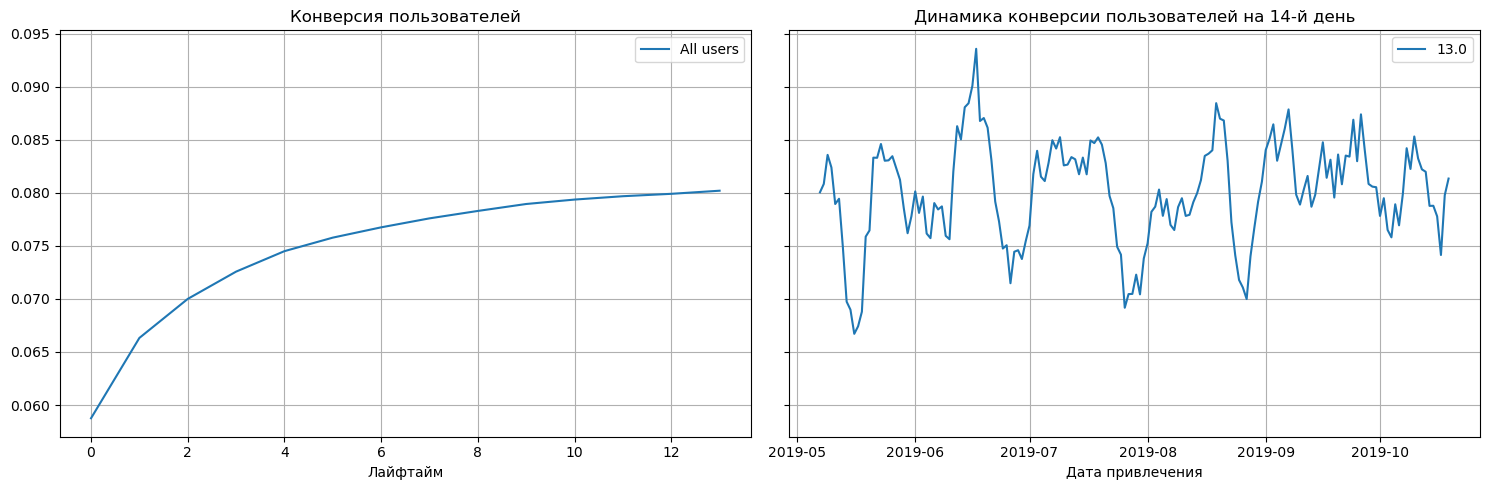

In [167]:
# график конверсии

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

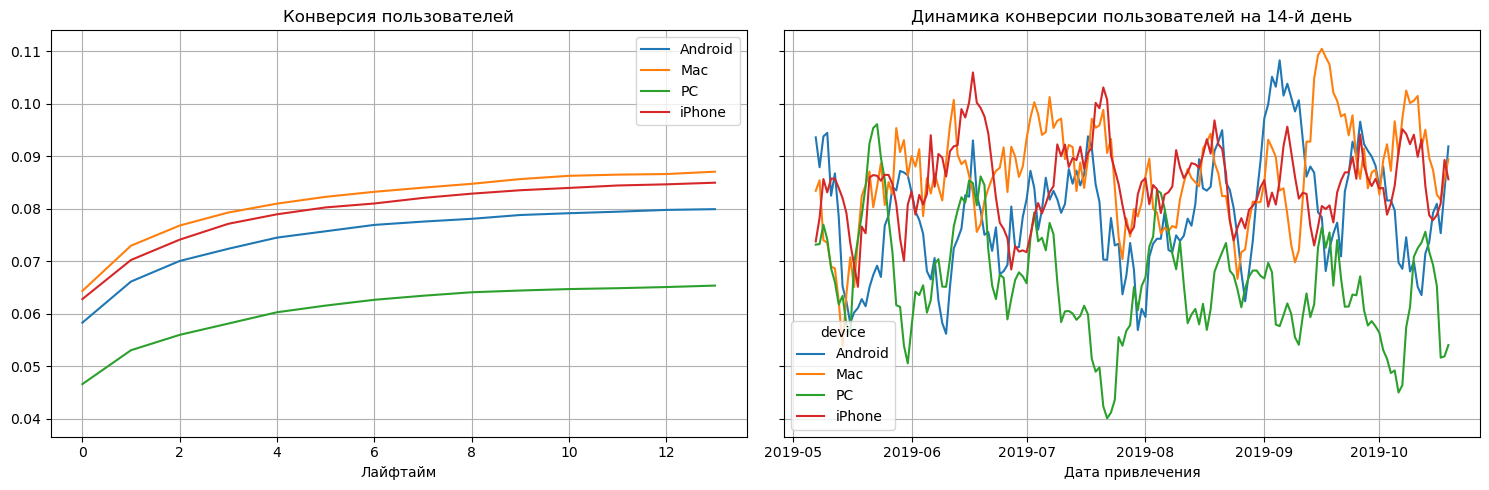

In [168]:
# график конверсии с разбивкой по устройствам

dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

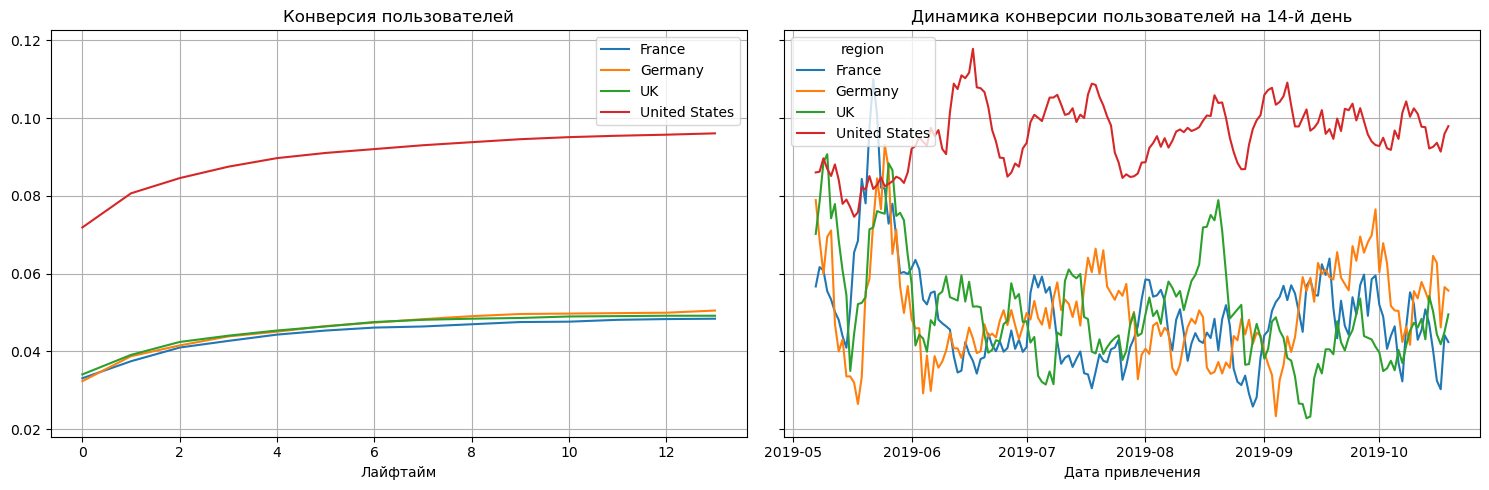

In [169]:
# график конверсии с разбивкой по странам

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

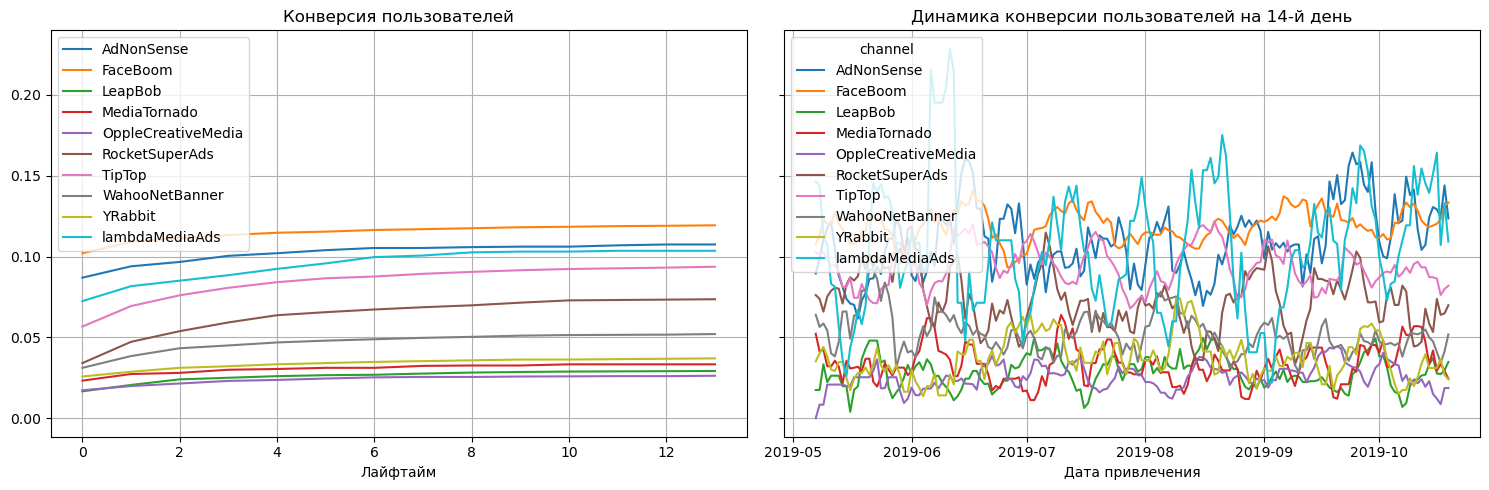

In [170]:
# график конверсии с разбивкой по каналам привлечения

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Общая конверсия стабильна, однако динамика неустойчивая.

Конверсия пользователей устройств Mac и iPhone выше.

Конверсия пользователей в США значительно выше, чем в других странах, конверсия которых резко снизилась в мае, июне, но уже не повышалась.

Конверсия пользователей источников FaceBoom выше остальных.

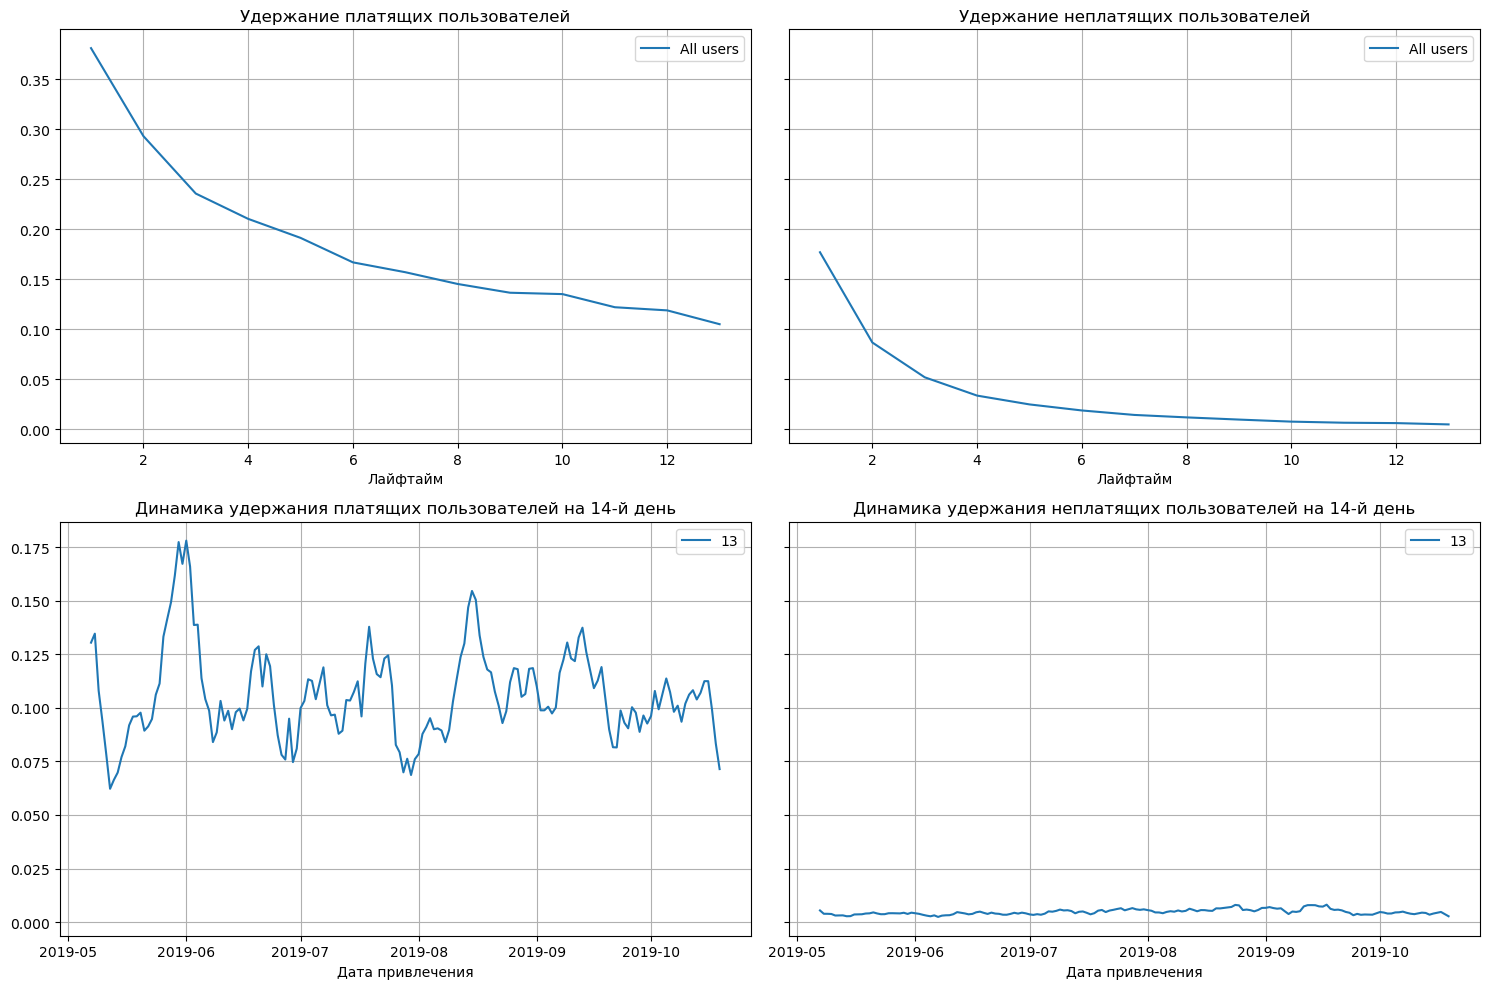

In [171]:
# график удержания

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days)

plot_retention(retention_grouped, retention_history, horizon_days)

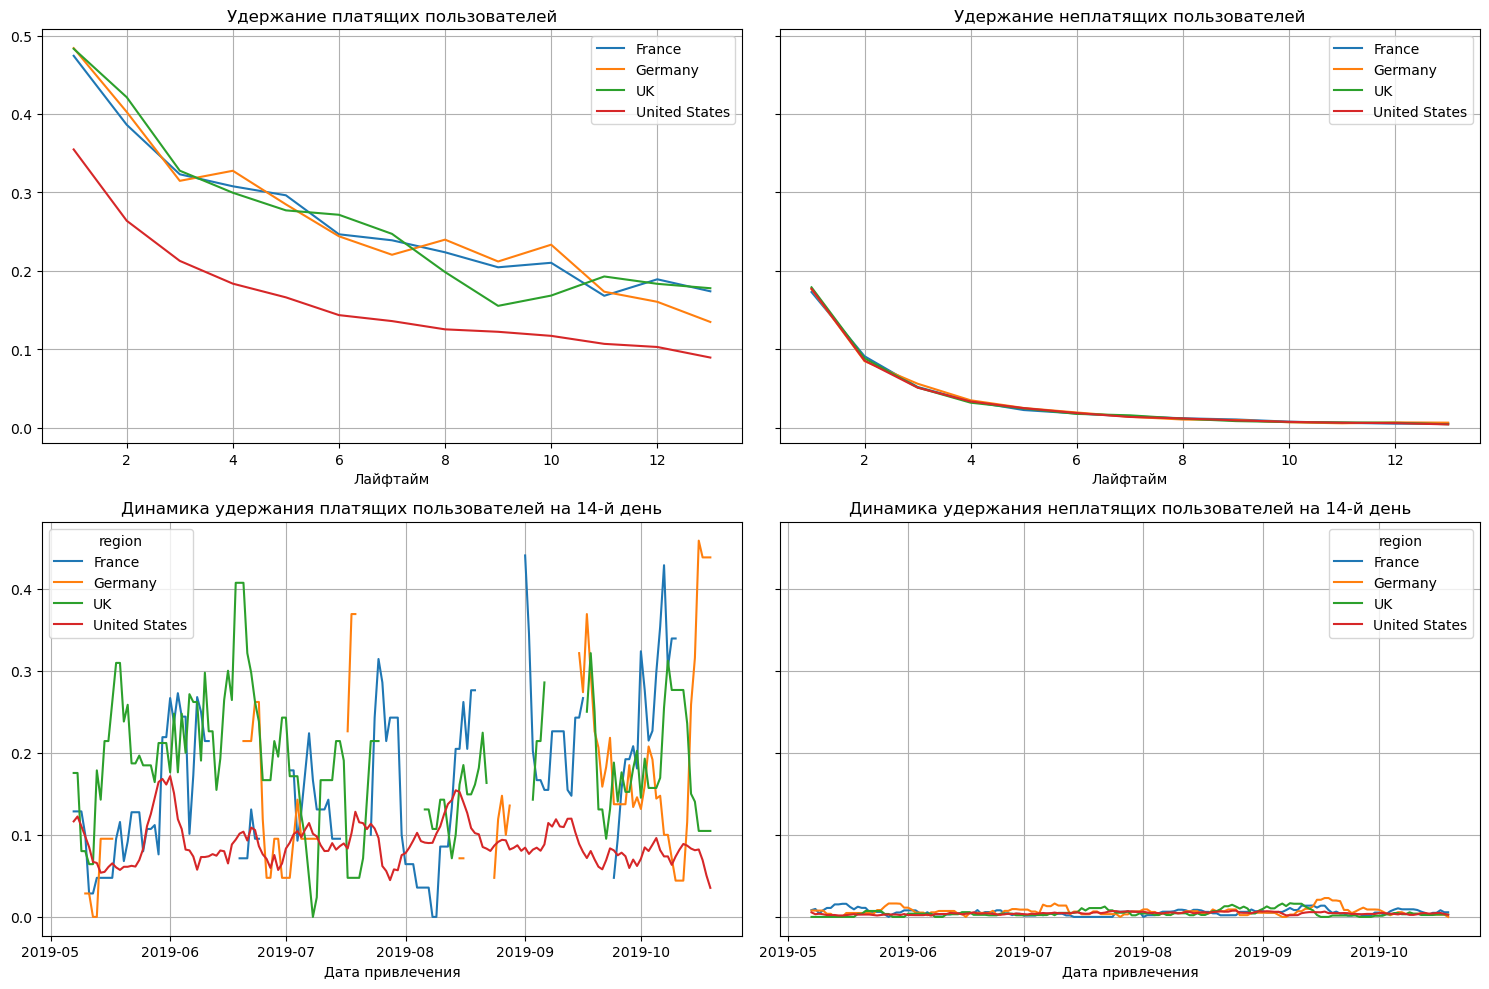

In [172]:
# график удержания с разбивкой по странам

dimensions = ['region']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

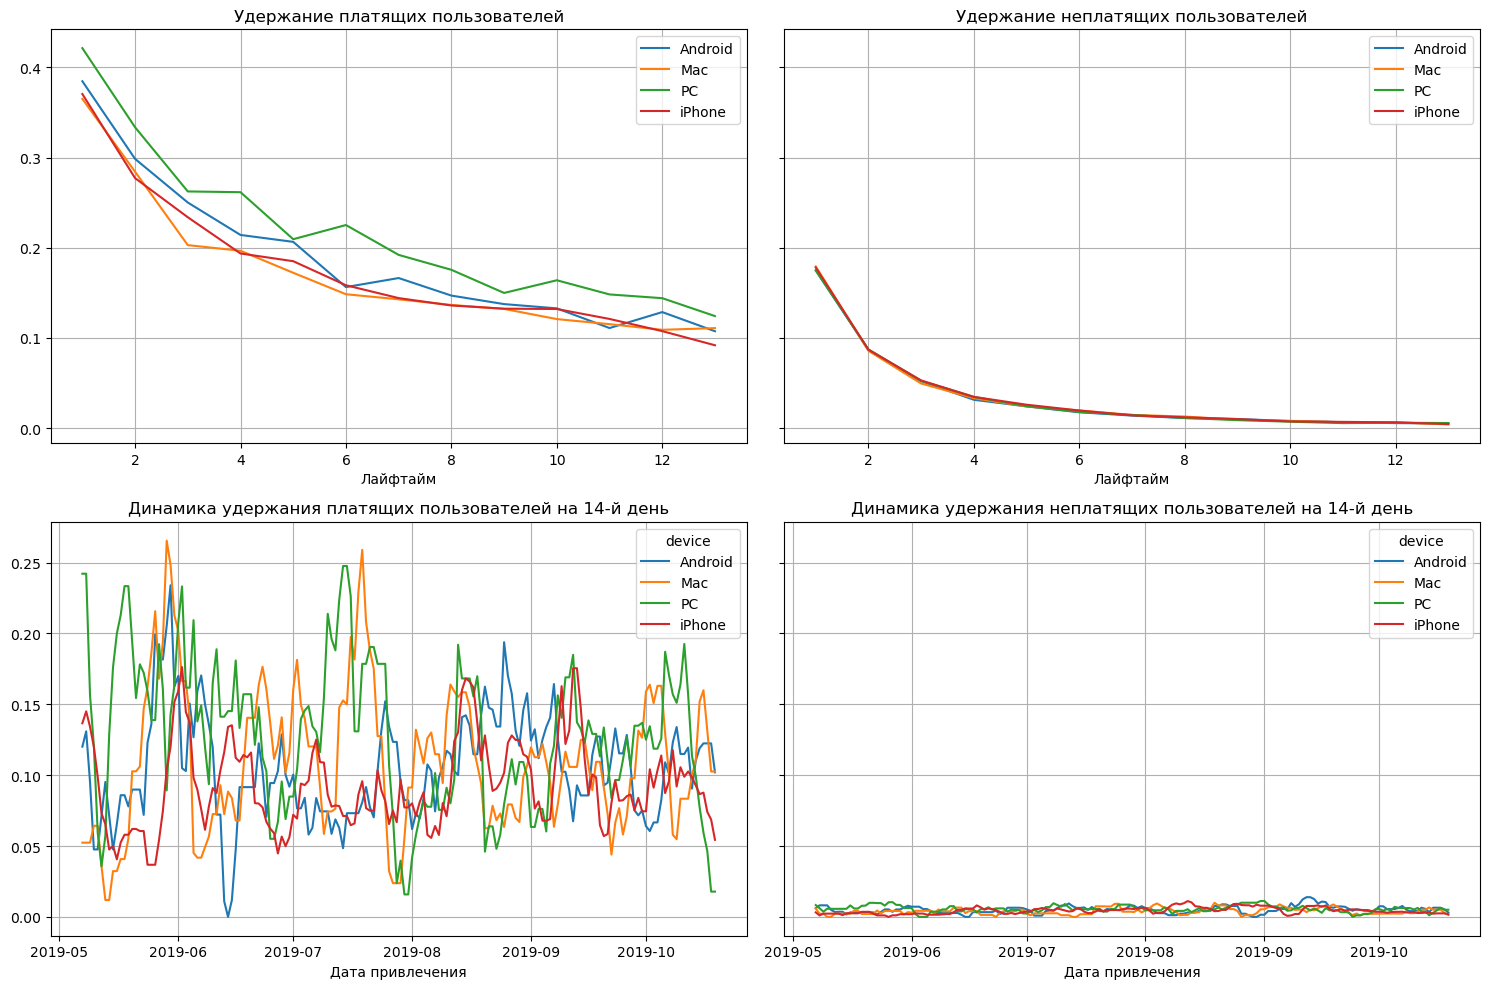

In [173]:
# график удержания с разбивкой по устройствам

dimensions = ['device']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

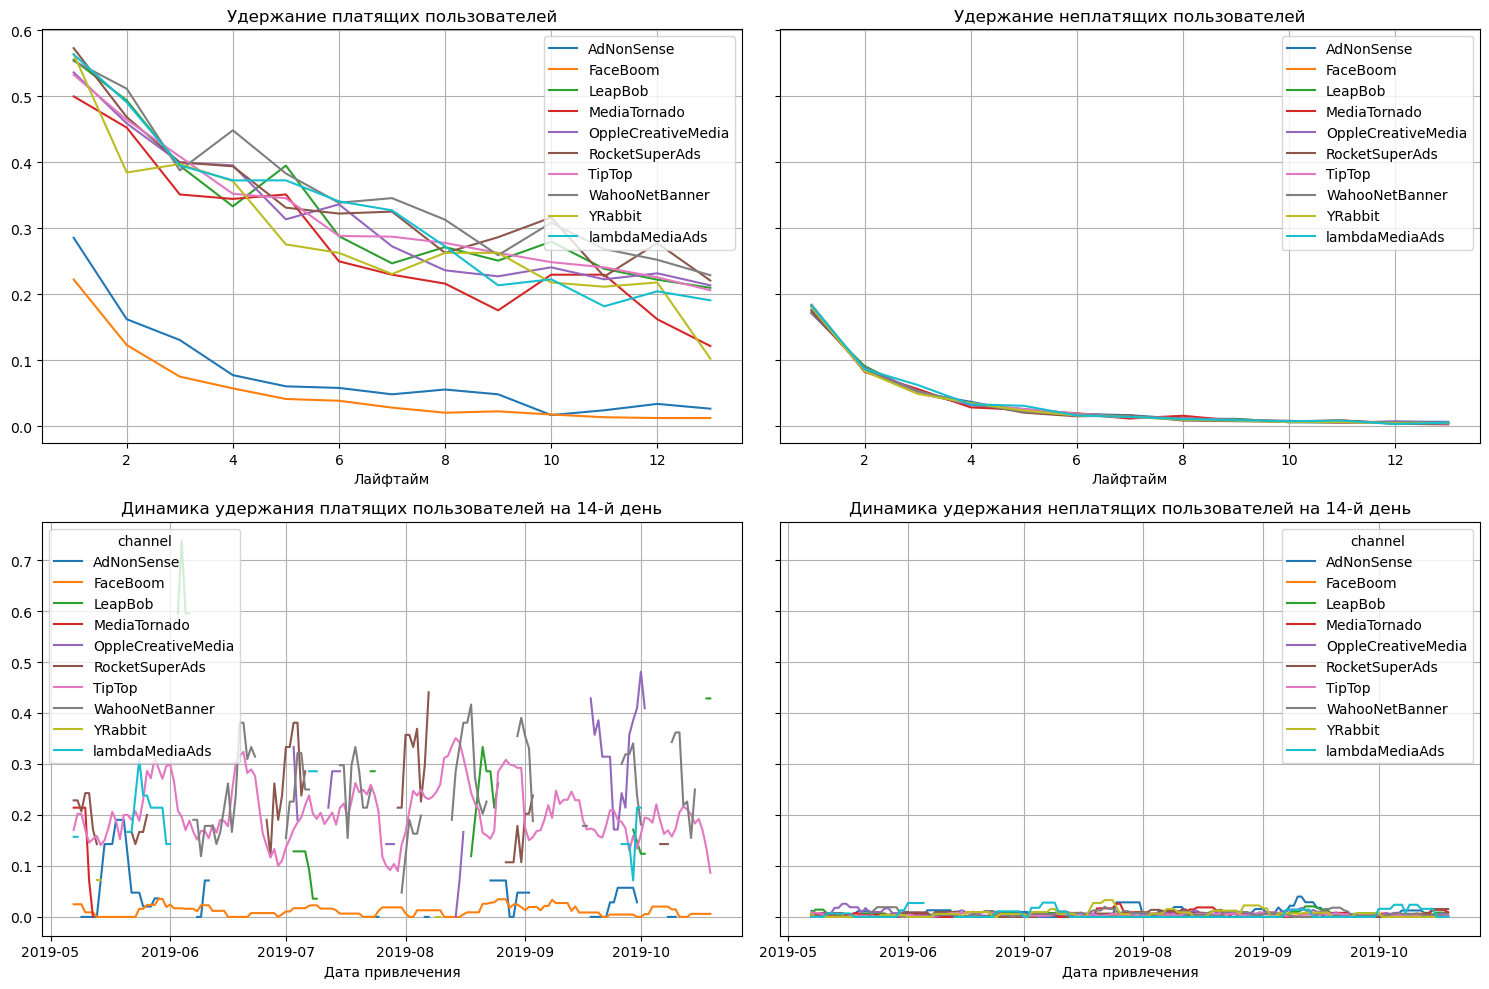

In [174]:
# график удержания с разбивкой источникам привлечения

dimensions = ['channel']

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

Показатель удержания платящих пользователей сильно снижается.

Удержание платящих пользователей в США значительно ниже, чем в других странах.

Удержание платящих пользователей устройств PC выше.

Удержание платящих пользователей источников AdNonSence и FaceBoom гораздо ниже, чем других источников.

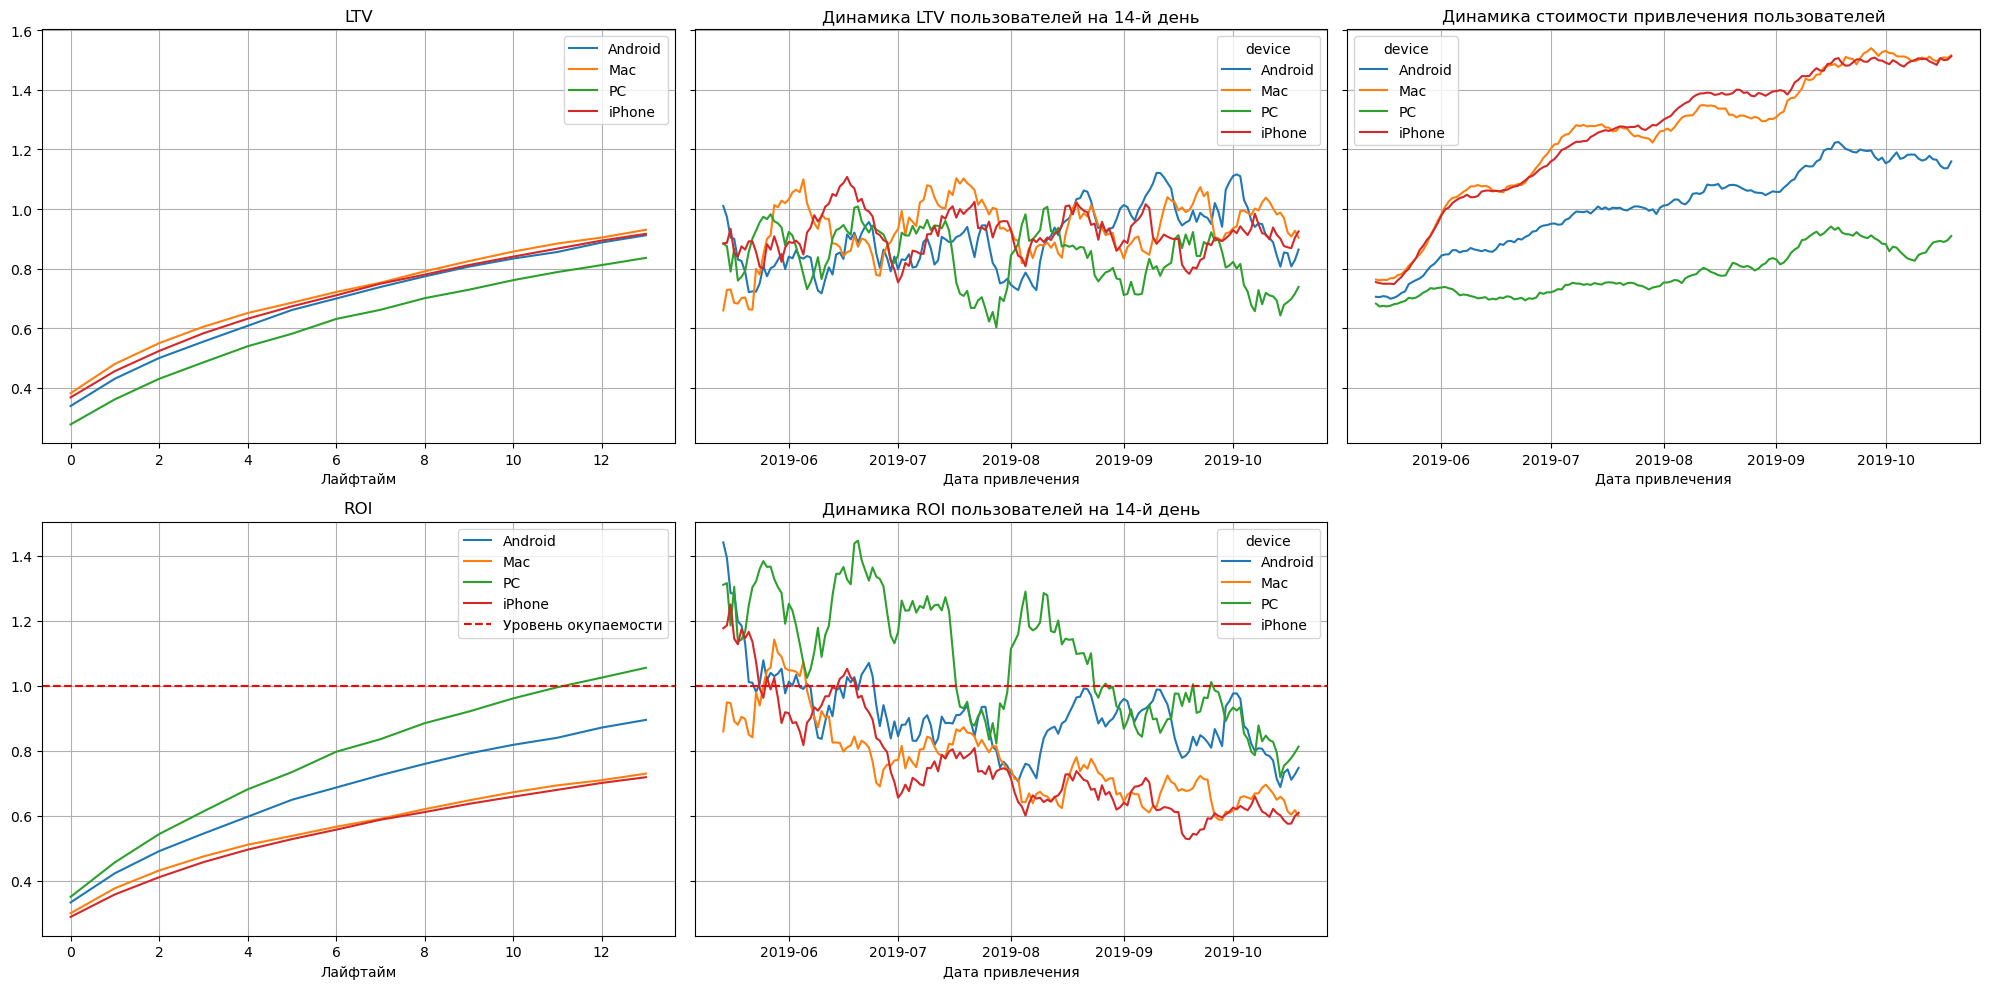

In [175]:
# графики LTV, ROI, CAC с разбивкой по устройствам

dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама окупается (ROI) среди пользователей PC гораздо лучше, чем среди пользователей iPhone и Mac.
Стоимость привлечения (CAC) пользователей iPhone и Mac гораздо выше, чем PC и Android.

У PC ниже всех CAC, а ROI выше.

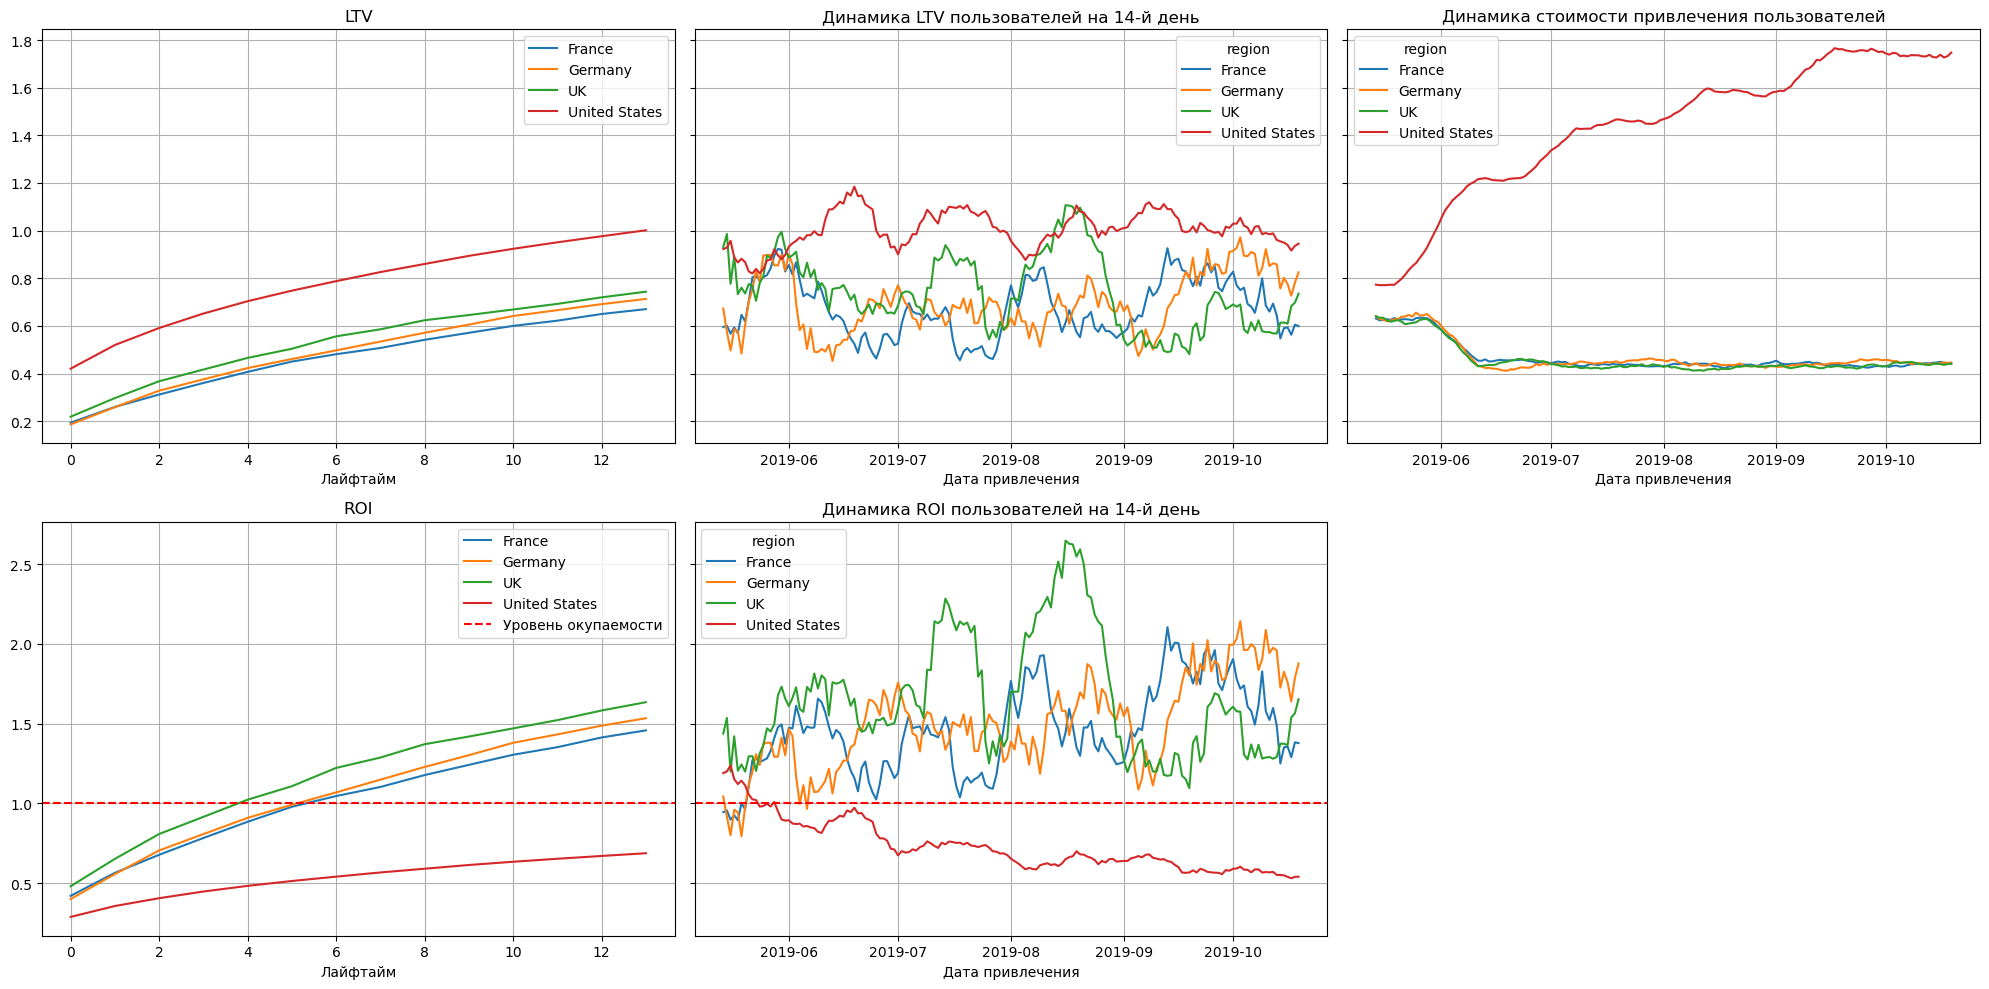

In [176]:
# графики LTV, ROI, CAC с разбивкой по странам

dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
)

Реклама окупается во всех странах, кроме США.

В США CAC сильно повышается непропорционально LTV. ROI снижается.

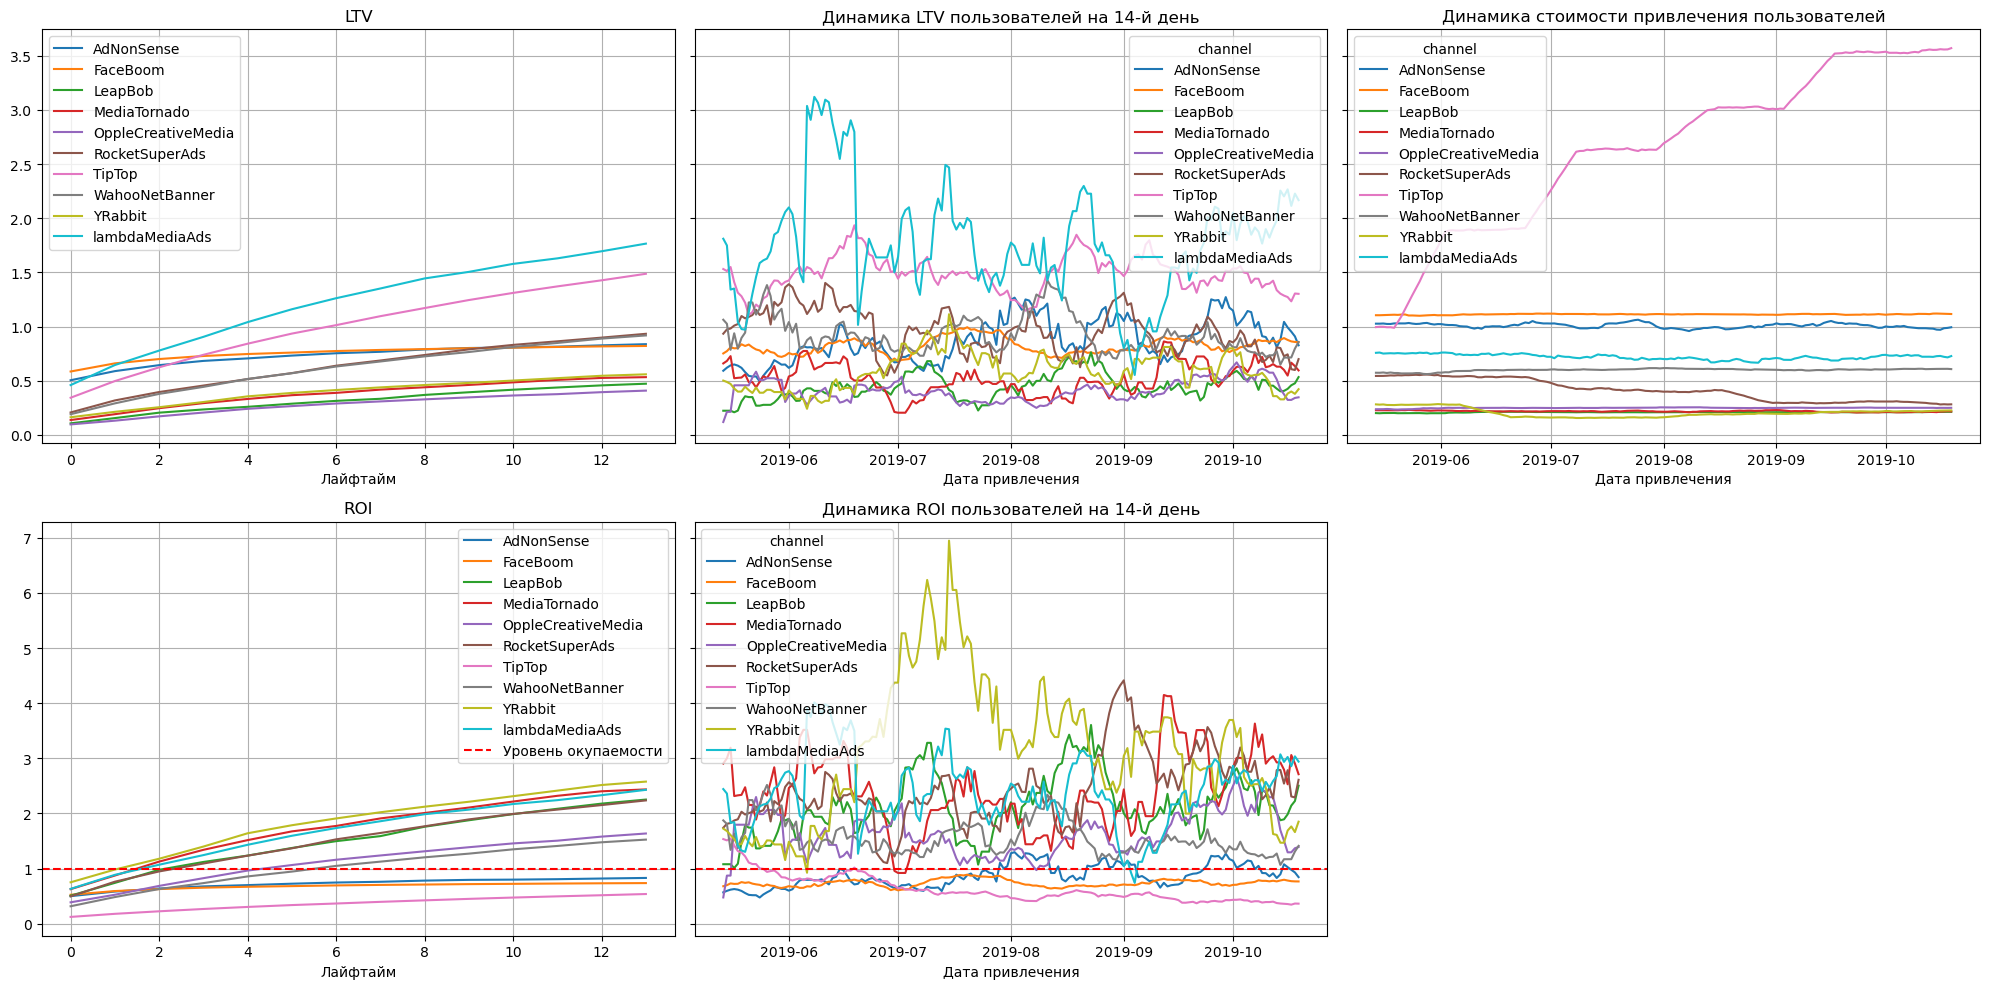

In [177]:
# графики LTV, ROI, CAC с разбивкой по каналам привлечения

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

Стоимость привлечения (CAC) у канала TipTop гораздо выше, чем у остальных, однако, окупаемость практически отсутствует.

LTV у канала lambdaMediaAds повышается и выше остальных каналов, а CAC стабильно низкий, реклама окупается.
Также реклама окупается у YRabbit за счёт самого низкого CAC.



В целом реклама не окупается. 
Реклама не окупается (ROI) среди пользователей устройств iPhone и Mac, в стране США и на каналах FaceBoom, TipTop, AdNonSense, также наблюдается высокий уровень расходов на рекламу.
Возможно стоит пересмотреть расходы на рекламу, перераспределить их. 

Проблемы окупаемости могут быть вызваны тем, что расходы на рекламу растут непропорционально LTV.

У канала TipTop стоимость привлечения растет, а удержание падает.

Удержание платящих пользователей источников AdNonSence и FaceBoom гораздо ниже, чем других источников, а CAC выше.

Выходит, что основная проблема в удержании.

Думаю, что необходимо перераспределить расходы на рекламу в пользу других устройств (Android и PC). Также выяснить что с удержанием пользователей (оно снижается).

Необходимо выяснить почему удержание на каналах TipTop, FaceBoom и AdNonSence падает.
Также низкое удержание в США при высокой конверсии и увеличением CAC.


#### Попытка разобраться в каналах привлечения пользователей по странам.

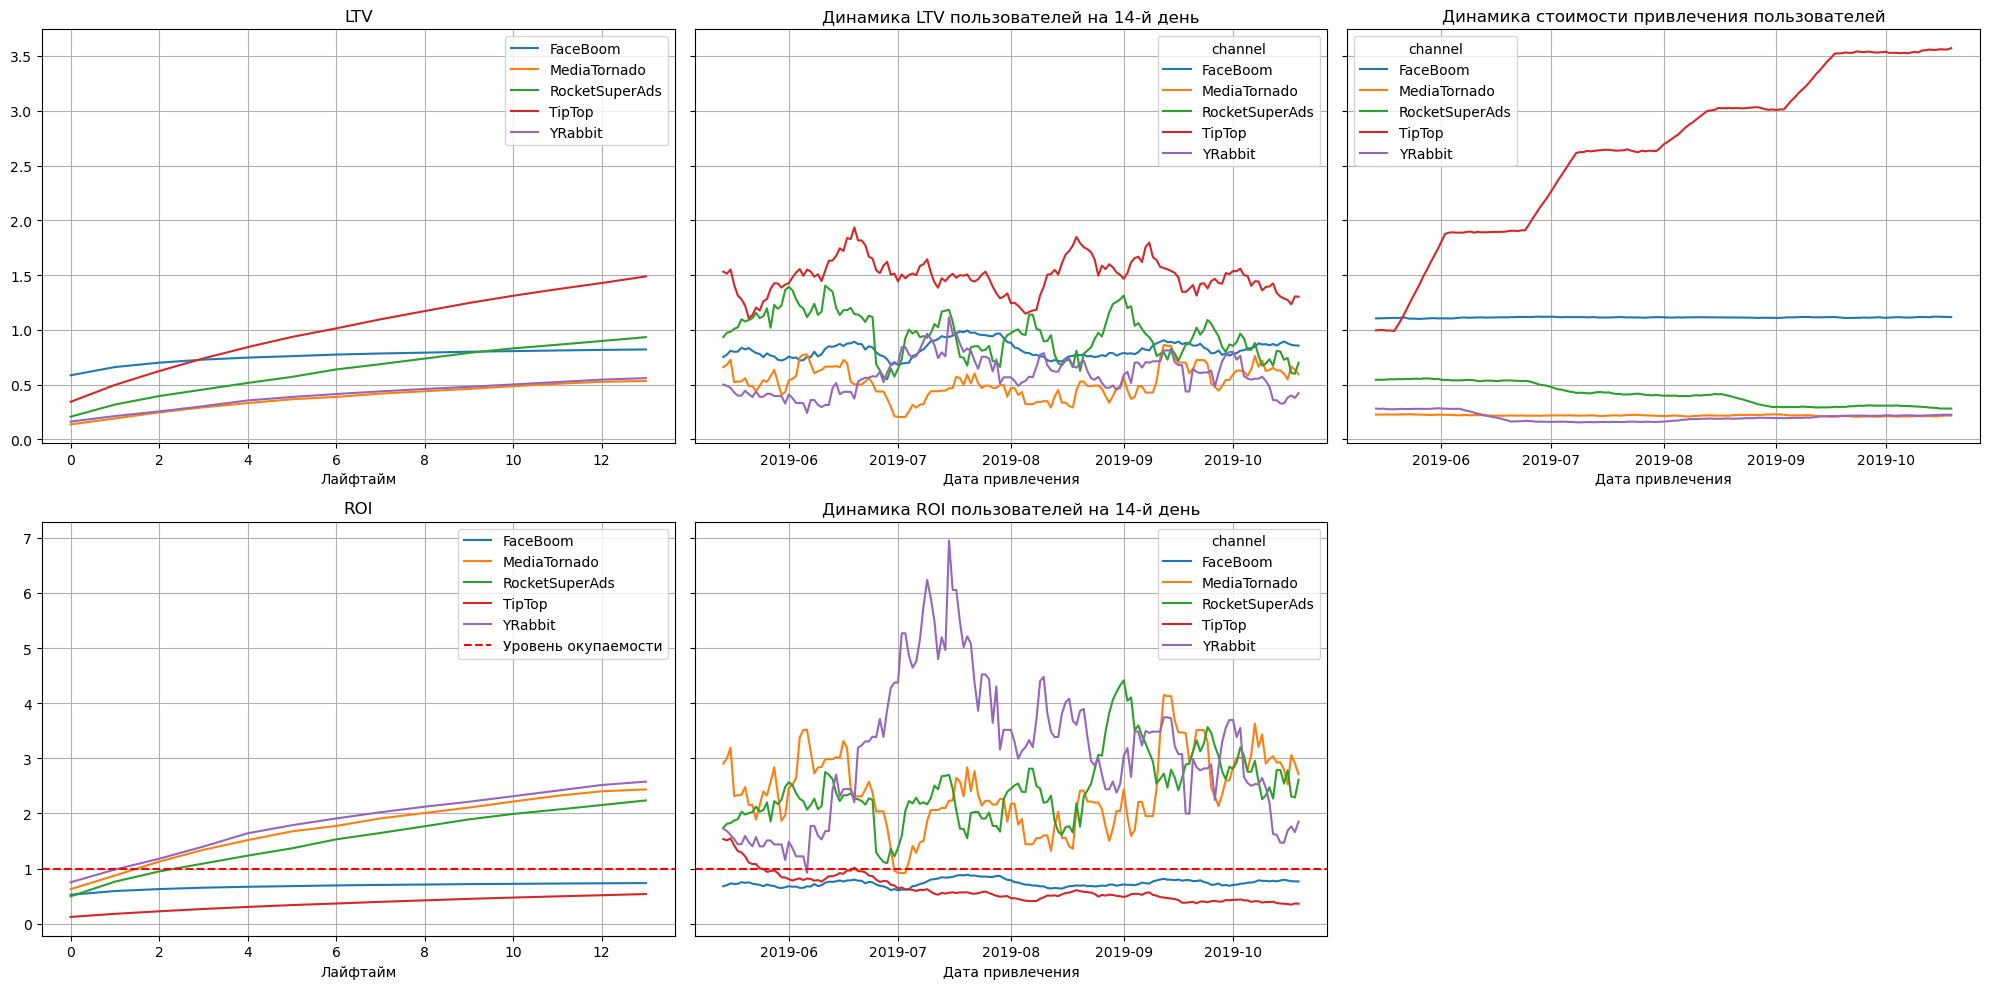

In [178]:
# графики LTV, ROI, CAC с разбивкой по каналам привлечения в США

profiles_us = profiles.query('region == "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

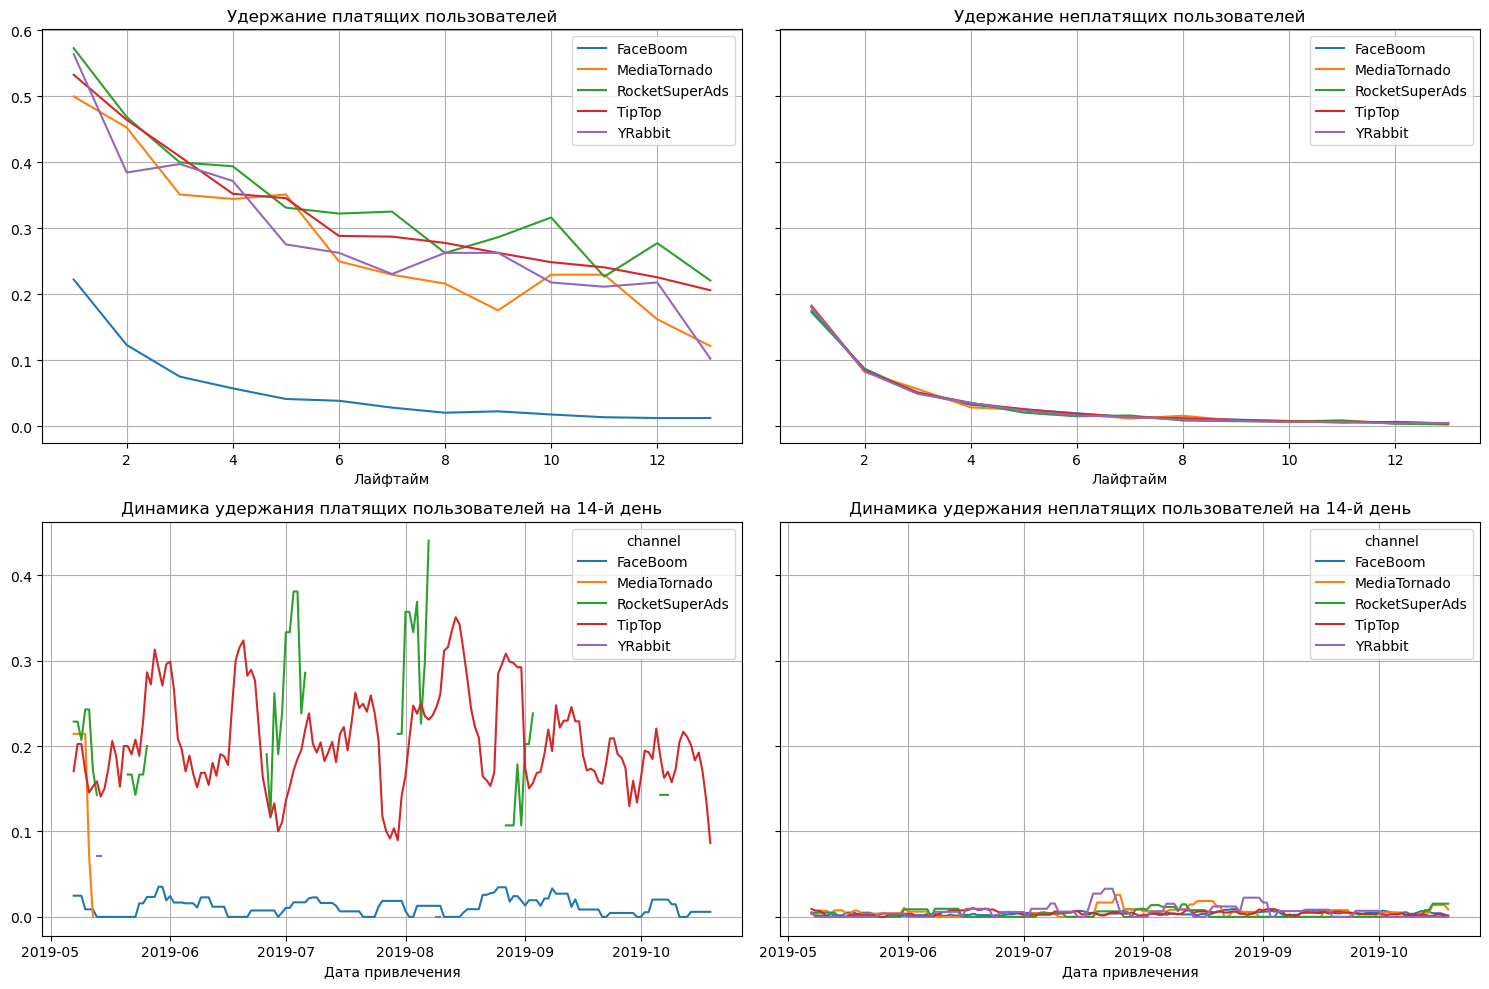

In [180]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_us, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

В США не окупаются (ROI) каналы привлечения FaceBoom и TipTop. FaceBoom - CAC стабильный, LTV тоже не меняется и крайне низкое удержание. TipTop - удержание падает, LTV повышается, но не соответственно CAC (очень высокий). 

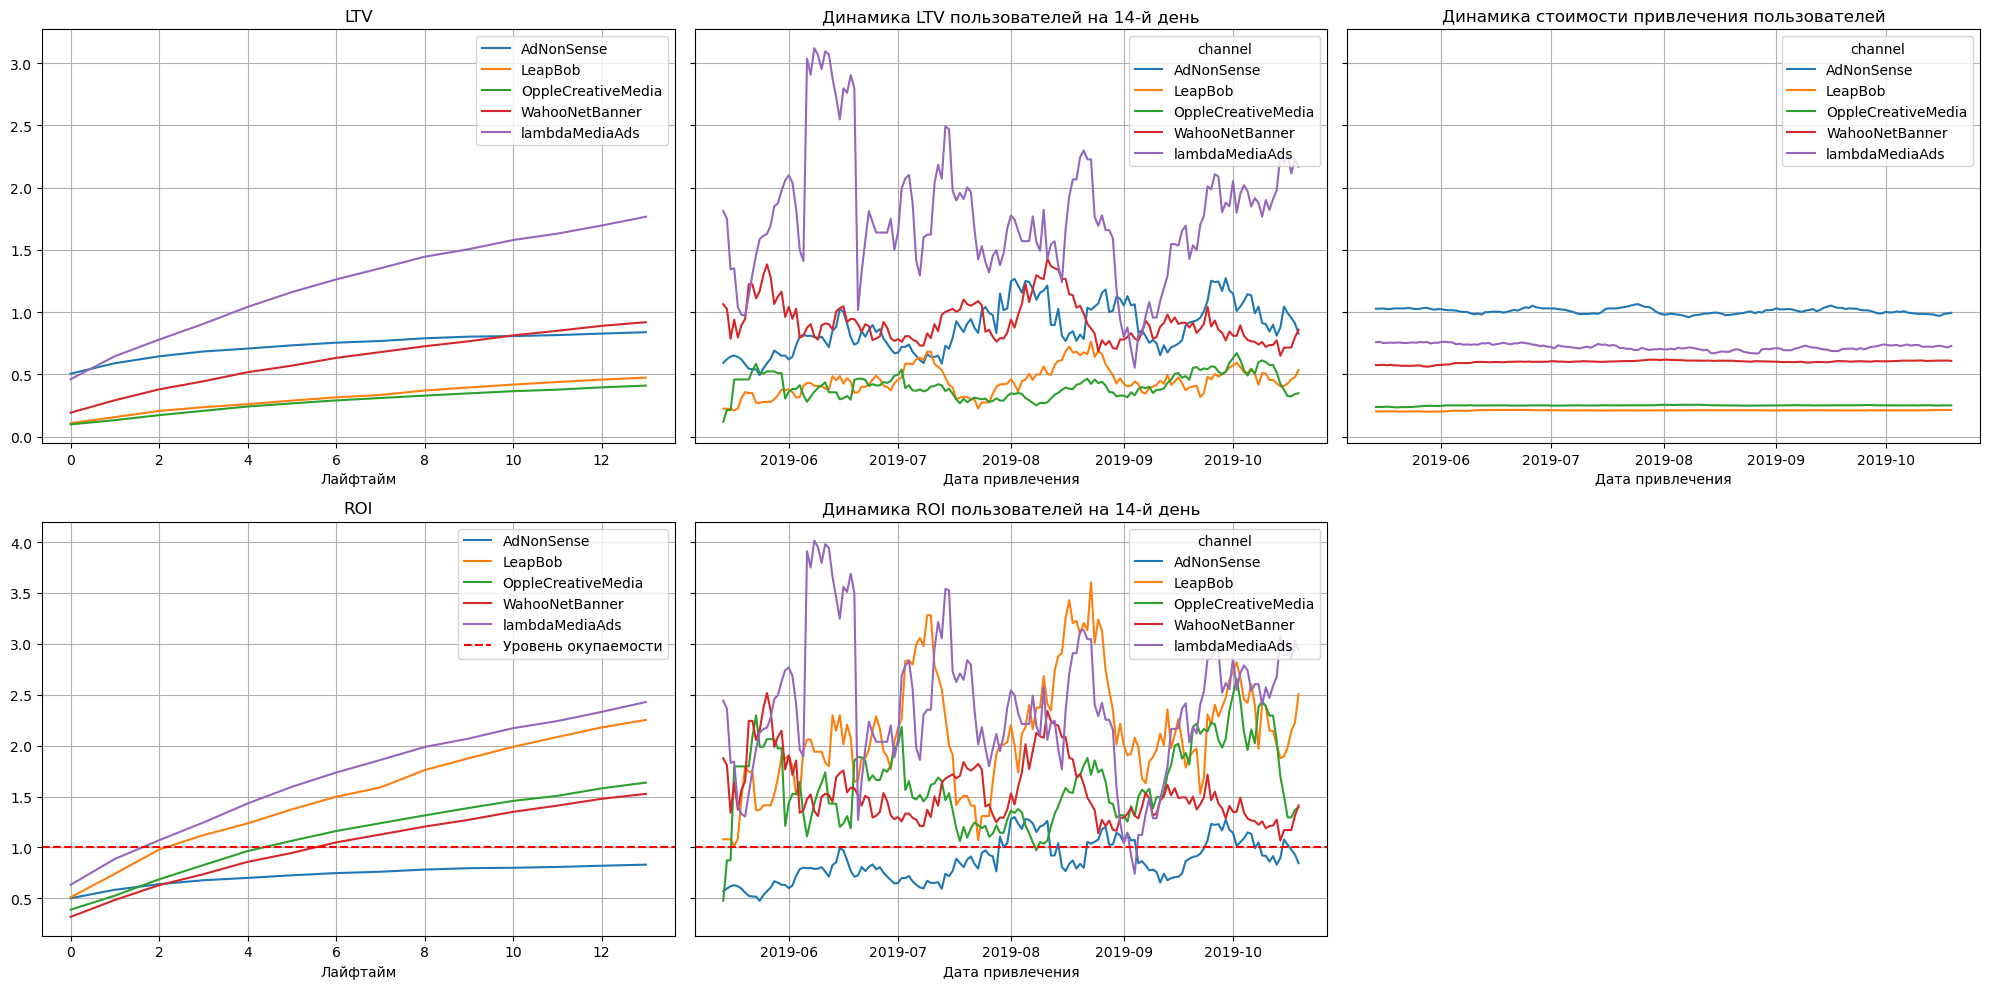

In [181]:
# графики LTV, ROI, CAC с разбивкой по каналам привлечения в других странах

profiles_no_us = profiles.query('region != "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_no_us, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

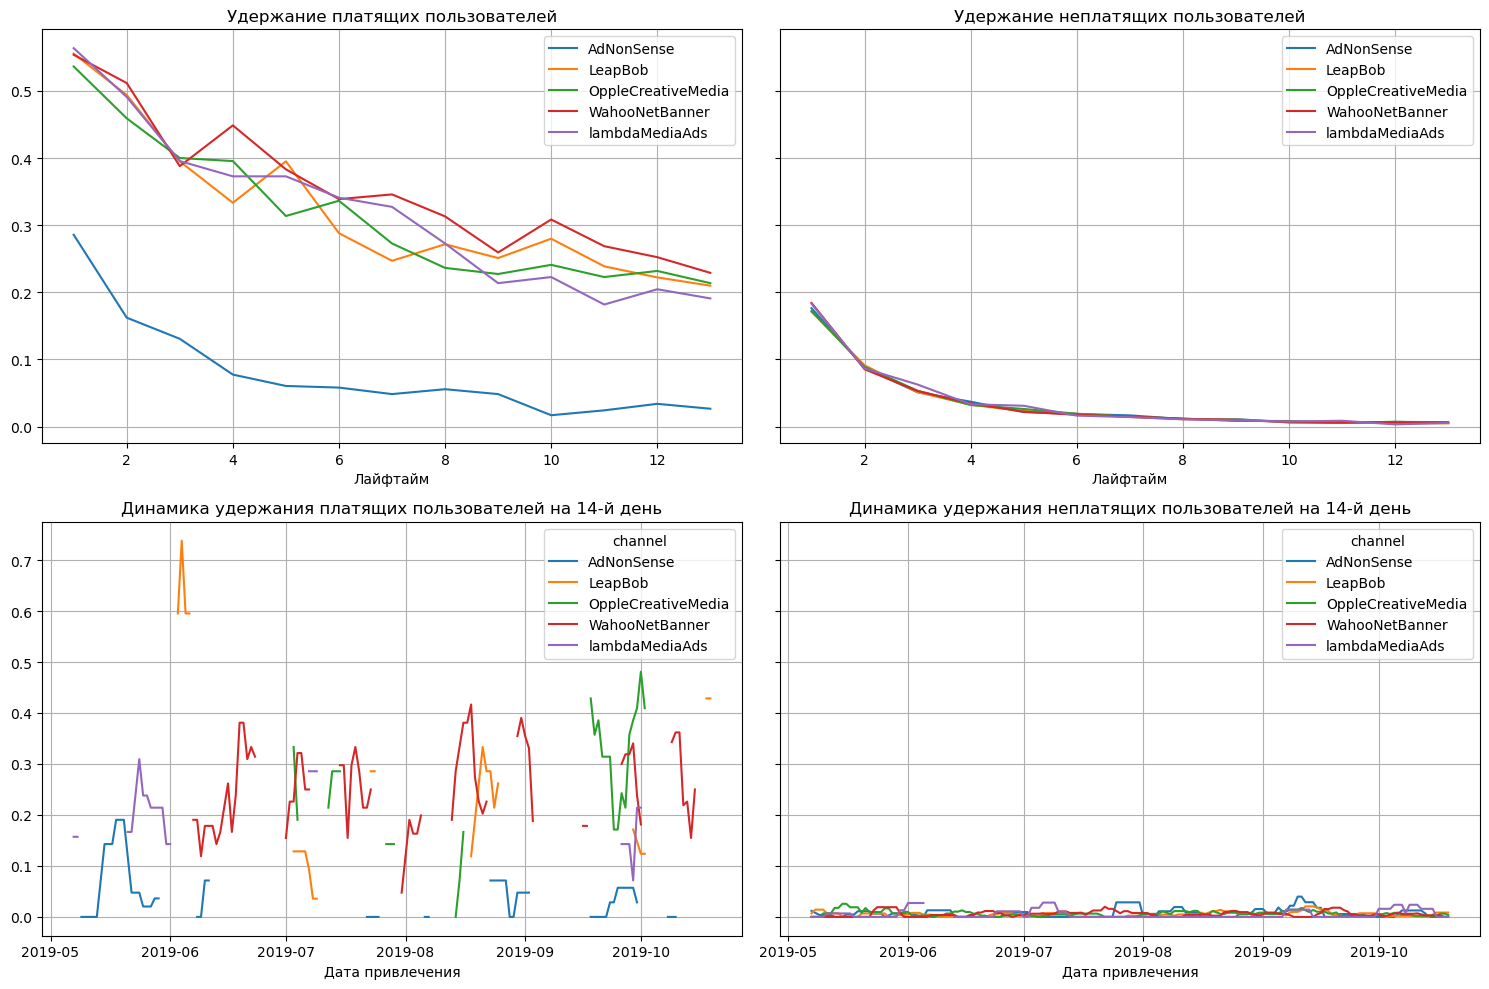

In [182]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_no_us, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

В других странах не окупается реклама в источнике AdNonSense, здесь очень низкое удержание пользователей.



В США низкий ROI из-за высоких расходов на рекламу (CAC), если такой уровень расходов обусловлен ценами на рекламу(TipTop), то возможно стоит пересмотреть и стоимость приложения для пользователей или перераспределить расходы на рекламу, выглядит как будто все средства направленны в основном на канал - TipTop, может быть целевая аудитория приложения отсутствует на вышеуказанном канале.

В других странах основной канал привлечения - AdNonSense, реклама в котором не окупается. 

Падает удержание пользователей во всех странах, в США изначально ниже остальных, возможно приложение не локализованно должным образом, не адаптированно для жителей стран или имеются какие-либо технические препятствия для пользователей: оплата приложения, поддержка.